In [15]:
import numpy as np
import matplotlib.pyplot as plt
from plyfile import PlyData, PlyElement
from scene.colmap_loader import qvec2rotmat
from utils.sh_utils import SH2RGB
import json

path = r"C:\Users\ralle\OneDrive\Dokumenter\fitted_gaussians\nisse\edited.ply"
max_sh_degree = 3
def sigmoid(z):
    return 1/(1 + np.exp(-z))


In [16]:
plydata = PlyData.read(path)
xyz = np.stack((np.asarray(plydata.elements[0]["x"]),
                np.asarray(plydata.elements[0]["y"]),
                np.asarray(plydata.elements[0]["z"])),  axis=1)
opacities = np.asarray(plydata.elements[0]["opacity"])[..., np.newaxis]

features_dc = np.zeros((xyz.shape[0], 3, 1))
features_dc[:, 0, 0] = np.asarray(plydata.elements[0]["f_dc_0"])
features_dc[:, 1, 0] = np.asarray(plydata.elements[0]["f_dc_1"])
features_dc[:, 2, 0] = np.asarray(plydata.elements[0]["f_dc_2"])

extra_f_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("f_rest_")]
extra_f_names = sorted(extra_f_names, key = lambda x: int(x.split('_')[-1]))
assert len(extra_f_names)==3*(max_sh_degree + 1) ** 2 - 3
features_extra = np.zeros((xyz.shape[0], len(extra_f_names)))
for idx, attr_name in enumerate(extra_f_names):
    features_extra[:, idx] = np.asarray(plydata.elements[0][attr_name])
# Reshape (P,F*SH_coeffs) to (P, F, SH_coeffs except DC)
features_extra = features_extra.reshape((features_extra.shape[0], 3, (max_sh_degree + 1) ** 2 - 1))

scale_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("scale_")]
scale_names = sorted(scale_names, key = lambda x: int(x.split('_')[-1]))
scales = np.zeros((xyz.shape[0], len(scale_names)))
for idx, attr_name in enumerate(scale_names):
    scales[:, idx] = np.asarray(plydata.elements[0][attr_name])

rot_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("rot")]
rot_names = sorted(rot_names, key = lambda x: int(x.split('_')[-1]))
rots = np.zeros((xyz.shape[0], len(rot_names)))
for idx, attr_name in enumerate(rot_names):
    rots[:, idx] = np.asarray(plydata.elements[0][attr_name])

active_sh_degree = max_sh_degree

downsample = 1
xyz = xyz[::downsample]
rots = rots[::downsample]
scales = scales[::downsample]
opacities = opacities[::downsample]
features_dc = features_dc[::downsample]
xyz.shape

(157291, 3)

In [17]:
data_dict = {}
for i, (loc, rot, scale, opacity, rgb) in enumerate(zip(xyz, rots, scales, opacities, SH2RGB(features_dc).squeeze())):

    data_dict[i] = {
        "xyz": loc.tolist(),
        "rot": qvec2rotmat(rot).tolist(),
        "scale": np.exp(scale).tolist(),
        "opacity": sigmoid(opacity).tolist(),
        "color_rgb" : rgb.tolist(), 
    }

In [18]:
n_levels = 4

x_subdivs = np.linspace(np.min(xyz[:,0]), np.max(xyz[:,0]), num = 2**n_levels + 1)
y_subdivs = np.linspace(np.min(xyz[:,1]), np.max(xyz[:,1]), num = 2**n_levels + 1)
z_subdivs = np.linspace(np.min(xyz[:,2]), np.max(xyz[:,2]), num = 2**n_levels + 1)



In [19]:
boxes = np.zeros((2**n_levels, 2**n_levels, 2**n_levels), dtype = bool)
indices = np.frompyfunc(list, 0, 1)(np.empty((2**n_levels, 2**n_levels, 2**n_levels), dtype=object))  


for gaussian_idx, (xyz_, rot, scale, opacity, rgb) in enumerate(zip(xyz, rots, scales, opacities, SH2RGB(features_dc).squeeze())):
    rot = qvec2rotmat(rot)
    scale = np.exp(scale) * 3

    zeros = np.zeros(3)
    points = []
    colors = []
    c = ["red", "green", "blue"]
    for i in range(3):
        val = scale[i]
        shift = np.zeros(3)
        shift[i] += val
        points.append(xyz_ + shift)
        points.append(xyz_ - shift)
        colors.extend([c[i]]*2)
    points = np.array(points)
    mu = np.mean(points, axis = 0)
    rotated_points = ((points-mu) @ rot) + mu

    x_min, y_min, z_min = rotated_points.min(axis=0)
    x_max, y_max, z_max = rotated_points.max(axis=0)

    x_check = (x_subdivs[1:] > x_min) & (x_subdivs[:-1] < x_max) | ((x_subdivs[:-1] <  x_min) & (x_subdivs[1:] > x_max))
    y_check = (y_subdivs[1:] > y_min) & (y_subdivs[:-1] < y_max) | ((y_subdivs[:-1] <  y_min) & (y_subdivs[1:] > y_max))
    z_check = (z_subdivs[1:] > z_min) & (z_subdivs[:-1] < z_max) | ((z_subdivs[:-1] <  z_min) & (z_subdivs[1:] > z_max))


    for i, x_i in enumerate(x_check):
        if x_i:
            for j, y_i in enumerate(y_check):
                if y_i:
                    for k, z_i in enumerate(z_check):
                        if z_i:
                            boxes[i,j,k] = True
                            indices[i,j,k].append(gaussian_idx)

In [21]:
# NO PRUNE
structure = {}
stats = {"c": 0}

def get_children(xs, ys, zs, ijk, level, idx, n_levels, indices):
    stats["c"] += 1
    parent_idx = idx
    box_data = {
        "mins": [xs[0], ys[0], zs[0], False],
        "maxs": [xs[-1], ys[-1], zs[-1]],
    }

    # If we've reached level n_levels+1, it's a leaf node
    if level == n_levels + 1:
        # Leaf node: get the final children from indices
        leaf_indices = indices[ijk[0], ijk[1], ijk[2]]

        # Ensure leaf_indices is always a list
        if np.isscalar(leaf_indices):
            leaf_indices = [leaf_indices]

        structure[parent_idx] = {
            "child_indices": leaf_indices,
            "mins": [xs[0], ys[0], zs[0], True],
            "maxs": [xs[-1], ys[-1], zs[-1]]
        }
        return parent_idx, parent_idx  # This subtree has only one node (the leaf)

    # Internal node: subdivide into 8 children
    child_indices = []
    split_x = xs.size // 2
    split_y = ys.size // 2
    split_z = zs.size // 2

    current_max_idx = parent_idx  # track the highest assigned index in this subtree
    for xc in (False, True):
        xs_sub = xs[:split_x+1] if not xc else xs[split_x:]
        x_bit = int(xc)

        for yc in (False, True):
            ys_sub = ys[:split_y+1] if not yc else ys[split_y:]
            y_bit = int(yc)

            for zc in (False, True):
                zs_sub = zs[:split_z+1] if not zc else zs[split_z:]
                z_bit = int(zc)

                # Update ijk for the child:
                # At each subdivision, we double the resolution and add 0 or 1 for each half.
                ijk_child = ijk * 2 + np.array([x_bit, y_bit, z_bit], dtype=int)

                # The next available index is current_max_idx + 1
                child_idx = current_max_idx + 1
                c_idx, c_last = get_children(xs_sub, ys_sub, zs_sub, ijk_child, level + 1, child_idx, n_levels, indices)
                # c_idx is the child's index, c_last is the last index used in that child's subtree

                child_indices.append(c_idx)
                current_max_idx = c_last  # update the maximum index used so far

    structure[parent_idx] = {"child_indices": child_indices, **box_data}
    return parent_idx, current_max_idx


stats["c"] = 0
root_idx, last_idx = get_children(x_subdivs, y_subdivs, z_subdivs, np.zeros(3, dtype=int), 1, 0, n_levels, indices)

print(f"Total nodes created: {stats['c']}")
print("Root node:", structure[root_idx])
print("Children of root node:", [structure[i] for i in structure[root_idx]["child_indices"]])


Total nodes created: 4681
Root node: {'child_indices': [1, 586, 1171, 1756, 2341, 2926, 3511, 4096], 'mins': [-1.0214495658874512, 0.6447857618331909, 2.3265936374664307, False], 'maxs': [2.2935333251953125, 3.0222456455230713, 4.868719100952148]}
Children of root node: [{'child_indices': [2, 75, 148, 221, 294, 367, 440, 513], 'mins': [-1.0214495658874512, 0.6447857618331909, 2.3265936374664307, False], 'maxs': [0.6360418796539307, 1.833515703678131, 3.5976563692092896]}, {'child_indices': [587, 660, 733, 806, 879, 952, 1025, 1098], 'mins': [-1.0214495658874512, 0.6447857618331909, 3.5976563692092896, False], 'maxs': [0.6360418796539307, 1.833515703678131, 4.868719100952148]}, {'child_indices': [1172, 1245, 1318, 1391, 1464, 1537, 1610, 1683], 'mins': [-1.0214495658874512, 1.833515703678131, 2.3265936374664307, False], 'maxs': [0.6360418796539307, 3.0222456455230713, 3.5976563692092896]}, {'child_indices': [1757, 1830, 1903, 1976, 2049, 2122, 2195, 2268], 'mins': [-1.0214495658874512, 

In [23]:
n_child = 0
leaf_nodes = 0
for box in structure.values():
    if box["mins"][3] and len(box["child_indices"]) != 0:
        n_child+=len(box["child_indices"])
        leaf_nodes += 1
print("average amount of gaussians per leaf node")
n_child/leaf_nodes

average amount of gaussians per leaf node


209.64382083108472

In [24]:
nonzero = 0
for k in indices.flatten():
    if len(k)>0:
        nonzero+=len(k)
print("gaussians are present in on average this many leaf nodes:")
nonzero/xyz.shape[0]

gaussians are present in on average this many leaf nodes:


2.46975351418708

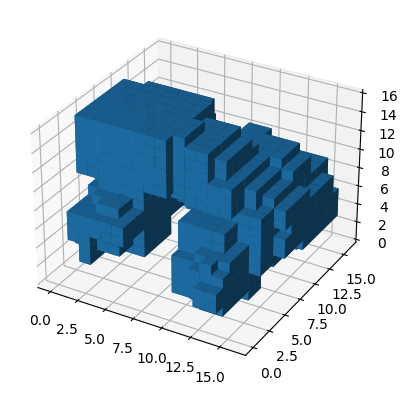

In [25]:


fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
 
ax.voxels(boxes)
plt.show()

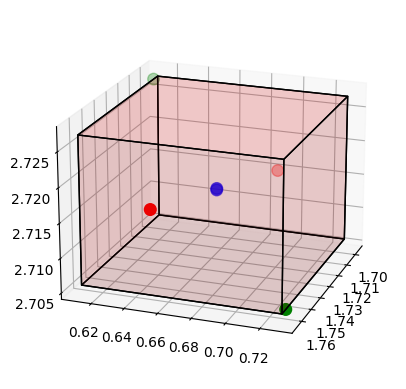

In [26]:
x_range = [x_min, x_max]
y_range = [y_min, y_max]
z_range = [z_min, z_max]
x, y, z = np.meshgrid(
    np.linspace(x_range[0], x_range[1], 2),
    np.linspace(y_range[0], y_range[1], 2),
    np.linspace(z_range[0], z_range[1], 2),
    indexing='ij'
)
voxels = np.ones((1, 1, 1), dtype=bool)  # A single cube around the extrema


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=20, azim=20)

ax.voxels(x, y, z, voxels, facecolors='red', edgecolor='k', alpha=0.1)

ax.scatter3D(rotated_points[:,0], rotated_points[:,1], rotated_points[:,2], c = colors, s = 70)
plt.show()

In [27]:
from pathlib import Path

with open(f"nisse_15k_NO_PRUNE.json", "w") as f:
    json.dump(data_dict, f, indent = 4)
with open(f"nisse_15k_spatial_NO_PRUNE.json", "w") as f:
    json.dump(dict(sorted(structure.items())), f, indent = 4)